<a href="https://colab.research.google.com/github/irfanshahmayeen/GR-08-CSE-445-Machine-Learnling-Stop-Sign-Detection-In-The-Street-/blob/Sadat/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [31]:
# Cell 1: Imports and Seed Setting
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss
import random




In [210]:
# Set a consistent random seed at the beginning of your notebook
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Define dataset path and categories (replace with your actual paths and categories)
dataset_path = "/content/drive/MyDrive/project_445/Dataset"
categories = ["Non stop sign", "Stop sign"]
IMG_SIZE = 64


Preprocessing and Feature Extraction

In [231]:
# Cell 2: Data Loading and Preprocessing with Augmentation
import os
import cv2
import numpy as np
from skimage.feature import hog
import random

# Define augmentation function
def augment_image(img):
    """Augment the image by flipping, rotating, and adding slight noise"""
    if random.choice([True, False]):
        img = cv2.flip(img, 1)  # Horizontal flip
    angle = random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((IMG_SIZE / 2, IMG_SIZE / 2), angle, 1)
    img = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE), borderMode=cv2.BORDER_REFLECT_101)
    noise = np.random.normal(0, 0.05, img.shape).astype(np.float32)
    img = np.clip(img + noise, 0, 1).astype(np.float32)
    return img

# Initialize empty lists
data = []
labels = []
original_images = []

# Load and preprocess images
for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img_original = cv2.imread(img_path)
        if img_original is None:
            print(f"Warning: Failed to load {img_path}")
            continue
        original_images.append(img_original)
        img = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0

        # Apply augmentation
        img_augmented = augment_image(img)

        img_gray_orig = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_equalized_orig = cv2.equalizeHist((img_gray_orig * 255).astype(np.uint8)) / 255.0
        hog_feat_orig = hog(img_equalized_orig, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        data.append(hog_feat_orig)
        labels.append(label)

        # Generate augmented sample and extract HOG features
        img_gray_aug = cv2.cvtColor(img_augmented, cv2.COLOR_RGB2GRAY)
        img_equalized_aug = cv2.equalizeHist((img_gray_aug * 255).astype(np.uint8)) / 255.0
        hog_feat_aug = hog(img_equalized_aug, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        data.append(hog_feat_aug)
        labels.append(label)

X = np.array(data)
y = np.array(labels)

print("Dataset loaded and preprocessed with basic augmentation (1 original + 1 augmented per image).")
print("X shape:", X.shape)
print("y shape:", y.shape)

Dataset loaded and preprocessed with basic augmentation (1 original + 1 augmented per image).
X shape: (200, 1764)
y shape: (200,)


Preprossed and feature extracted

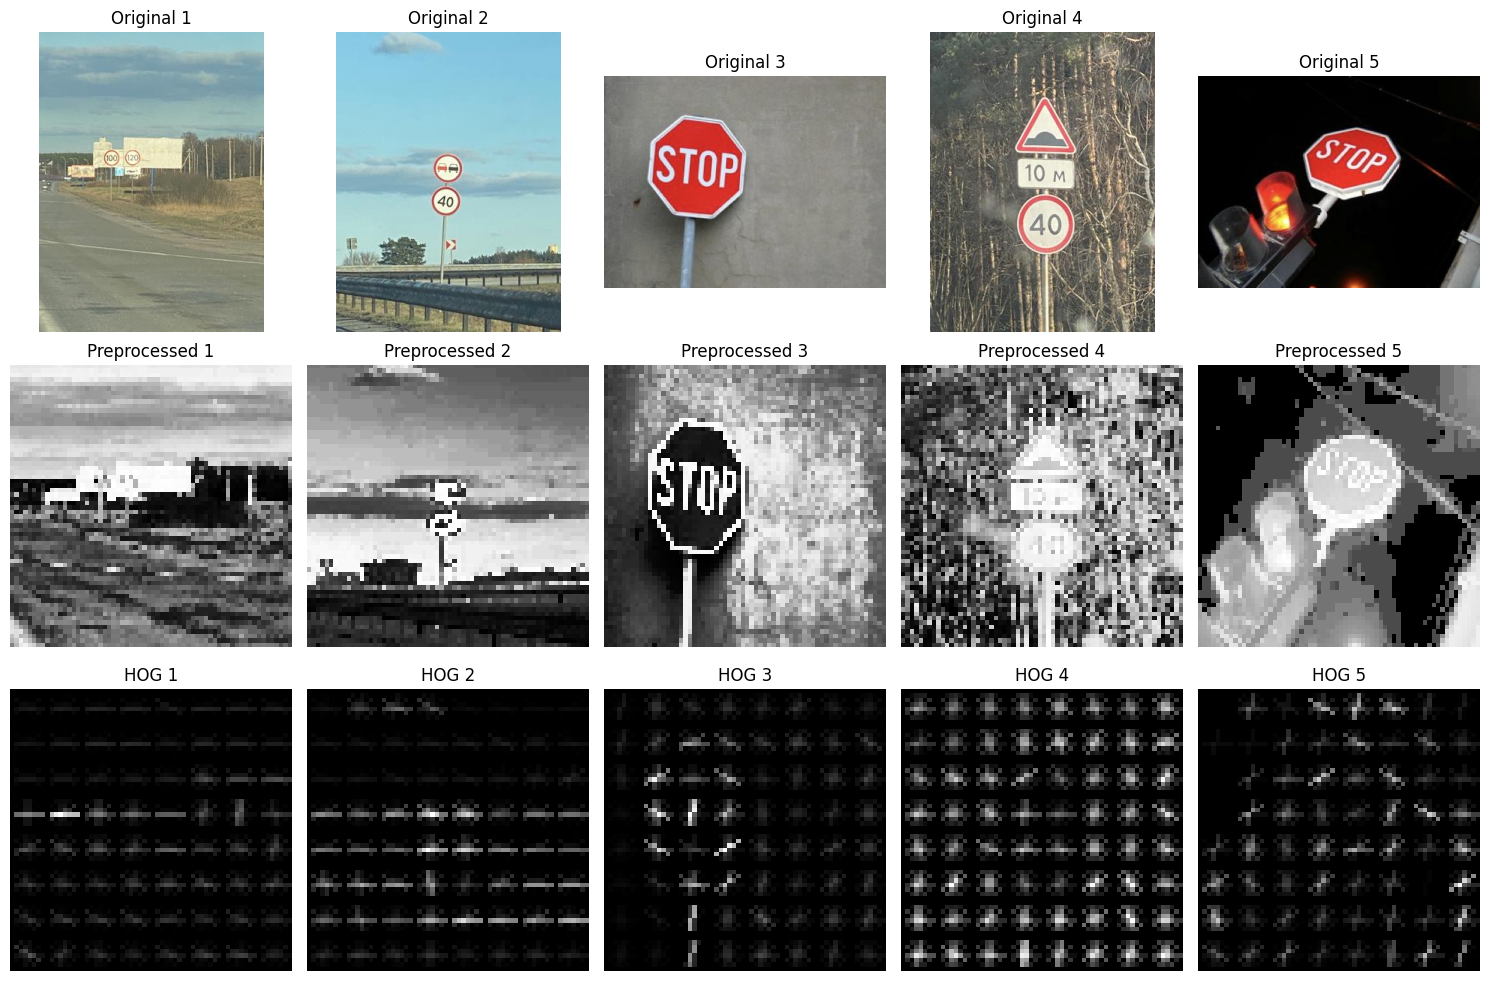

In [212]:
# Function to plot HOG features on top of the original image
def plot_hog(image, hog_image):
    """Plot HOG features on top of the original image."""
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

# Combine all the images and labels into a list of tuples
image_data = list(zip(original_images, labels))  # [(image, label), ...]
random.shuffle(image_data)  # Shuffle the images and labels randomly

# Plot the images for the first 5 samples
plt.figure(figsize=(15, 10))

for i in range(5):
    img_original, label = image_data[i]
    img_resized = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))

    # Convert to grayscale and equalize histogram for visualization
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_equalized = cv2.equalizeHist(img_gray)

    # Extracted HOG features for visualization
    fd, hog_image = hog(img_equalized,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True,
                        feature_vector=False)

    # Plot original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    plt.title(f'Original {i + 1}')
    plt.axis('off')

    # Plot preprocessed image (grayscale with histogram equalization)
    plt.subplot(3, 5, i + 6)
    plt.imshow(img_equalized, cmap='gray')
    plt.title(f'Preprocessed {i + 1}')
    plt.axis('off')

    # Plot HOG feature-extracted image
    plt.subplot(3, 5, i + 11)
    plot_hog(img_resized, hog_image)  # Plot HOG features
    plt.title(f'HOG {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Split the Dataset into Training, Validation, and Test Sets

In [232]:
# Cell 3: Data Splitting
from sklearn.model_selection import train_test_split

# Split into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed, stratify=y_temp)

# Verify all splits
print("\nTraining set:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nValidation set:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\nTest set:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

assert X_train.shape[0] == y_train.shape[0], "Training set mismatch!"
assert X_val.shape[0] == y_val.shape[0], "Validation set mismatch!"
assert X_test.shape[0] == y_test.shape[0], "Test set mismatch!"

print("\nData split into training, validation, and test sets.")


Training set:
X_train shape: (120, 1764)
y_train shape: (120,)

Validation set:
X_val shape: (40, 1764)
y_val shape: (40,)

Test set:
X_test shape: (40, 1764)
y_test shape: (40,)

Data split into training, validation, and test sets.


feature scaling

In [233]:
# Cell 4: Feature Scaling
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Features scaled using StandardScaler.")
print("X_train shape (scaled):", X_train.shape)
print("X_val shape (scaled):", X_val.shape)
print("X_test shape (scaled):", X_test.shape)

Features scaled using StandardScaler.
X_train shape (scaled): (120, 1764)
X_val shape (scaled): (40, 1764)
X_test shape (scaled): (40, 1764)


XGBoost Model parameter tuning

In [234]:
# Cell 5: XGBoost Parameter Tuning
import xgboost as xgb
from sklearn.metrics import log_loss

# Define parameter grid to search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_boost_round': [100, 200, 300],
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]  # Test balanced and unbalanced
}

# Base parameters (fixed)
base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': random_seed
}

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Store results
best_params = None
best_val_logloss = float('inf')
results = []

# Grid search over parameter combinations
for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        for num_boost_round in param_grid['num_boost_round']:
            for scale_pos_weight in param_grid['scale_pos_weight']:
                # Update parameters
                params = base_params.copy()
                params['max_depth'] = max_depth
                params['learning_rate'] = learning_rate
                params['scale_pos_weight'] = scale_pos_weight

                # Train model with current parameters
                model = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dtrain, 'train'), (dval, 'val')],
                    early_stopping_rounds=20,
                    verbose_eval=False
                )

                # Predict on validation set
                y_val_pred_proba = model.predict(dval)
                val_logloss = log_loss(y_val, y_val_pred_proba)

                # Store results
                results.append({
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'num_boost_round': num_boost_round,
                    'scale_pos_weight': scale_pos_weight,
                    'val_logloss': val_logloss,
                    'best_iteration': model.best_iteration
                })

                # Update best parameters
                if val_logloss < best_val_logloss:
                    best_val_logloss = val_logloss
                    best_params = params.copy()
                    best_params['num_boost_round'] = model.best_iteration

                print(f"Tested: max_depth={max_depth}, learning_rate={learning_rate}, "
                      f"num_boost_round={num_boost_round}, scale_pos_weight={scale_pos_weight:.2f}, "
                      f"val_logloss={val_logloss:.4f}")

# Print best results
print("\nBest parameters:", best_params)
print(f"Best validation log loss: {best_val_logloss:.4f}")

Tested: max_depth=3, learning_rate=0.01, num_boost_round=100, scale_pos_weight=1.00, val_logloss=0.5460
Tested: max_depth=3, learning_rate=0.01, num_boost_round=100, scale_pos_weight=1.00, val_logloss=0.5460
Tested: max_depth=3, learning_rate=0.01, num_boost_round=200, scale_pos_weight=1.00, val_logloss=0.5169
Tested: max_depth=3, learning_rate=0.01, num_boost_round=200, scale_pos_weight=1.00, val_logloss=0.5169
Tested: max_depth=3, learning_rate=0.01, num_boost_round=300, scale_pos_weight=1.00, val_logloss=0.4831
Tested: max_depth=3, learning_rate=0.01, num_boost_round=300, scale_pos_weight=1.00, val_logloss=0.4831
Tested: max_depth=3, learning_rate=0.05, num_boost_round=100, scale_pos_weight=1.00, val_logloss=0.4522
Tested: max_depth=3, learning_rate=0.05, num_boost_round=100, scale_pos_weight=1.00, val_logloss=0.4522
Tested: max_depth=3, learning_rate=0.05, num_boost_round=200, scale_pos_weight=1.00, val_logloss=0.4314
Tested: max_depth=3, learning_rate=0.05, num_boost_round=200, sc

Train Final Model with Best Parameters

In [235]:
# Cell 6: Train Final Model with Best Parameters
# Ensure 'best_params' is defined from the previous cell

if best_params:
    dtrain_final = xgb.DMatrix(X_train, label=y_train)
    dval_final = xgb.DMatrix(X_val, label=y_val)  # Optional: Evaluate on validation during final training

    final_xgb_model = xgb.train(
        best_params,
        dtrain_final,
        num_boost_round=best_params['num_boost_round'],
        evals=[(dtrain_final, 'train'), (dval_final, 'val')],
        verbose_eval=True
    )

    print("\nFinal XGBoost model training completed with best parameters.")
else:
    print("Error: Best parameters not found. Run the parameter tuning cell first.")

[0]	train-logloss:0.62992	val-logloss:0.66132


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-logloss:0.57687	val-logloss:0.63825
[2]	train-logloss:0.52596	val-logloss:0.61505
[3]	train-logloss:0.48553	val-logloss:0.59763
[4]	train-logloss:0.44933	val-logloss:0.58477
[5]	train-logloss:0.41224	val-logloss:0.57722
[6]	train-logloss:0.38290	val-logloss:0.55482
[7]	train-logloss:0.35320	val-logloss:0.54642
[8]	train-logloss:0.32715	val-logloss:0.53036
[9]	train-logloss:0.30295	val-logloss:0.51997
[10]	train-logloss:0.28061	val-logloss:0.51782
[11]	train-logloss:0.26250	val-logloss:0.50758
[12]	train-logloss:0.24494	val-logloss:0.50352
[13]	train-logloss:0.23014	val-logloss:0.49399
[14]	train-logloss:0.21659	val-logloss:0.48992
[15]	train-logloss:0.20317	val-logloss:0.48267
[16]	train-logloss:0.19225	val-logloss:0.47836
[17]	train-logloss:0.18328	val-logloss:0.47708
[18]	train-logloss:0.17251	val-logloss:0.48261
[19]	train-logloss:0.16327	val-logloss:0.48039
[20]	train-logloss:0.15522	val-logloss:0.47421
[21]	train-logloss:0.14786	val-logloss:0.47021
[22]	train-logloss:0.1

Test Set

In [236]:
# Cell 7: Evaluate Final Model on Test Set
# Ensure 'final_xgb_model', 'X_test', and 'y_test' are defined

if 'final_xgb_model' in locals():
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_test_pred_proba = final_xgb_model.predict(dtest)
    test_logloss = log_loss(y_test, y_test_pred_proba)

    # You can also calculate other metrics like accuracy
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    from sklearn.metrics import accuracy_score
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("\nFinal Model Evaluation on Test Set:")
    print(f"Test Log Loss: {test_logloss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
else:
    print("Error: Final XGBoost model not trained. Run the training cell first.")


Final Model Evaluation on Test Set:
Test Log Loss: 0.5321
Test Accuracy: 0.7250


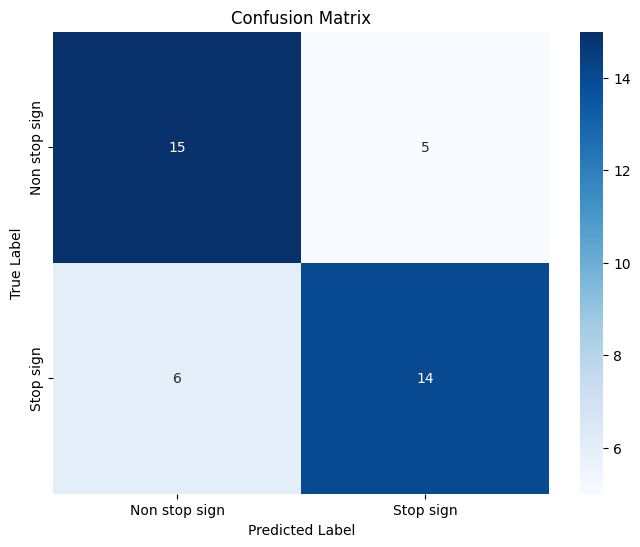


Classification Report:
               precision    recall  f1-score   support

Non stop sign       0.71      0.75      0.73        20
    Stop sign       0.74      0.70      0.72        20

     accuracy                           0.72        40
    macro avg       0.73      0.72      0.72        40
 weighted avg       0.73      0.72      0.72        40



In [237]:
# Cell 8: Confusion Matrix and Other Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'final_xgb_model', 'X_test', and 'y_test' are defined

if 'final_xgb_model' in locals():
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_test_pred_proba = final_xgb_model.predict(dtest)
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=categories))

else:
    print("Error: Final XGBoost model not trained. Run the training cell first.")